In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn

import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import glob
import os
# from tensorflow.keras.models import load_model

# from tensorflow.keras.models import Model
import os
import warnings


from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset



In [3]:
class_ranges = [(15, 22),(232,40),(400,60),(60,80)]

print(class_ranges[1][1])

40


In [4]:


class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.gender_mapping = {'male': 0, 'female': 1}
        self.ethnicity_mapping = {'white': 0, 'black': 1, 'asian': 2, 'hispanic': 3}


    def __len__(self):
        return len(self.data)


    
    def getAgeLabel(self,value1):

    # Define class ranges
        class_ranges = [(15, 22),(22,40),(40,60),(60,80)]
    
    # Check if both values fall into the same class range
        if(class_ranges[0][0]<=value1 and value1<class_ranges[0][1]):
            return 0
        elif(class_ranges[1][0]<=value1 and value1<class_ranges[1][1]):
            return 1
        elif(class_ranges[2][0]<=value1 and value1<class_ranges[2][1]):
            return 2
        elif(class_ranges[3][0]<=value1 and value1<class_ranges[3][1]):
            return 3
        else:
            return 0
   

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = '/home/csgrad/byalavar/FHE/celebSet/CELEBTEST/CELEBTEST/'+row['name']+'/' + row['filename']  # Assuming images are in a folder named 'images'
        
        try:
            image = Image.open(image_path)
        except Exception as e:
            # Handle the error, for example, you can return a placeholder image
            print("here")
            #self.__getitem__(idx + 1)
            #image = Image.new('RGB', (224, 224))  # Create a blank image
        
        image = Image.open(image_path)
        age = row['age']
        
        if(row['age']<=0):
            age=35
        label = {
            'age': self.getAgeLabel(age),
            'gender': self.gender_mapping.get(row['gender'], 0),  # -1 for unknown
            'ethnicity': self.ethnicity_mapping.get(row['ethnicity'], 0),
            'age1':age
        
        }
        #print(row['name'])
        if self.transform:
            image = self.transform(image)

        return image, label



In [5]:
# csv_file = '/home/csgrad/byalavar/FHE/celebSet/celebSET_final_v1.csv'  # Replace with the actual path to your CSV file
# df = pd.read_csv(csv_file)

# # Create a list to store the indices of rows with missing files
# rows_to_remove = []
# count=0
# # Iterate through the DataFrame and check if the files exist
# for index, row in df.iterrows():
#     image_path = '/home/csgrad/byalavar/FHE/celebSet/CELEBTEST/CELEBTEST/'+row['name']+'/' + row['filename'] 
#     if not os.path.exists(image_path):
#         rows_to_remove.append(index)
#         count=count+1
# df = df.drop(rows_to_remove)
# df.to_csv(csv_file, index=False)
# print(count)

In [6]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Resize the image to the desired size
    transforms.ToTensor(),          # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


In [7]:
trainSet = CustomDataset('/home/csgrad/byalavar/FHE/celebSet/celebSET_final_v1.csv', transform=transform)
trainloader = DataLoader(trainSet, batch_size=128, shuffle=True)

testSet = CustomDataset('/home/csgrad/byalavar/FHE/celebSet/final_clebSET_test.csv', transform=transform)
testloader = DataLoader(testSet, batch_size=128, shuffle=False)


In [7]:
def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


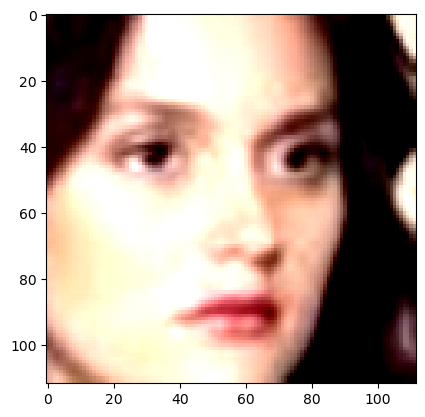

tensor(0) tensor(21) tensor(1) tensor(0)


In [8]:
tempIter = iter(trainloader)
images,labels = next(tempIter)
imshow(images[0])
print(labels['age'][0],labels['age1'][0],labels['gender'][0],labels['ethnicity'][0])

In [9]:
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout, MaxPool2d, \
    AdaptiveAvgPool2d, Sequential, Module
from collections import namedtuple


# Support: ['IR_50', 'IR_101', 'IR_152', 'IR_SE_50', 'IR_SE_101', 'IR_SE_152']


class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def l2_norm(input, axis=1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)

    return output


class SEModule(Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc1 = Conv2d(
            channels, channels // reduction, kernel_size=1, padding=0, bias=False)

        nn.init.xavier_uniform_(self.fc1.weight.data)

        self.relu = ReLU(inplace=True)
        self.fc2 = Conv2d(
            channels // reduction, channels, kernel_size=1, padding=0, bias=False)

        self.sigmoid = Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return module_input * x


class bottleneck_IR(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride, bias=False), BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False), PReLU(depth),
            Conv2d(depth, depth, (3, 3), stride, 1, bias=False), BatchNorm2d(depth))

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)

        return res + shortcut


class bottleneck_IR_SE(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR_SE, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride, bias=False),
                BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
            PReLU(depth),
            Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
            BatchNorm2d(depth),
            SEModule(depth, 16)
        )

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)

        return res + shortcut


class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
    '''A named tuple describing a ResNet block.'''


def get_block(in_channel, depth, num_units, stride=2):

    return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
    if num_layers == 50:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=4),
            get_block(in_channel=128, depth=256, num_units=14),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 100:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=13),
            get_block(in_channel=128, depth=256, num_units=30),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 152:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=8),
            get_block(in_channel=128, depth=256, num_units=36),
            get_block(in_channel=256, depth=512, num_units=3)
        ]

    return blocks


class Backbone(Module):
    def __init__(self, input_size, num_layers, mode='ir'):
        super(Backbone, self).__init__()
        assert input_size[0] in [112, 224], "input_size should be [112, 112] or [224, 224]"
        assert num_layers in [50, 100, 152], "num_layers should be 50, 100 or 152"
        assert mode in ['ir', 'ir_se'], "mode should be ir or ir_se"
        blocks = get_blocks(num_layers)
        if mode == 'ir':
            unit_module = bottleneck_IR
        elif mode == 'ir_se':
            unit_module = bottleneck_IR_SE
        self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1, bias=False),
                                      BatchNorm2d(64),
                                      PReLU(64))
        if input_size[0] == 112:
            self.output_layer = Sequential(BatchNorm2d(512),
                                           Dropout(),
                                           Flatten(),
                                           Linear(512 * 7 * 7, 512),
                                           BatchNorm1d(512))
        else:
            self.output_layer = Sequential(BatchNorm2d(512),
                                           Dropout(),
                                           Flatten(),
                                           Linear(512 * 14 * 14, 512),
                                           BatchNorm1d(512))

        modules = []
        for block in blocks:
            for bottleneck in block:
                modules.append(
                    unit_module(bottleneck.in_channel,
                                bottleneck.depth,
                                bottleneck.stride))
        self.body = Sequential(*modules)

        self._initialize_weights()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.body(x)
        x = self.output_layer(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()


def IR_50(input_size):
    """Constructs a ir-50 model.
    """
    model = Backbone(input_size, 50, 'ir')

    return model


def IR_101(input_size):
    """Constructs a ir-101 model.
    """
    model = Backbone(input_size, 100, 'ir')

    return model


def IR_152(input_size):
    """Constructs a ir-152 model.
    """
    model = Backbone(input_size, 152, 'ir')

    return model


def IR_SE_50(input_size):
    """Constructs a ir_se-50 model.
    """
    model = Backbone(input_size, 50, 'ir_se')

    return model


def IR_SE_101(input_size):
    """Constructs a ir_se-101 model.
    """
    model = Backbone(input_size, 100, 'ir_se')

    return model


def IR_SE_152(input_size):
    """Constructs a ir_se-152 model.
    """
    model = Backbone(input_size, 152, 'ir_se')

    return model

In [10]:
arcFaceModel = IR_50([112,112])
arcFaceModel.load_state_dict(torch.load("/home/csgrad/byalavar/FHE/HEAAN/FA_CVPR_Exp/backbone_ir50_ms1m_epoch120.pth"))

<All keys matched successfully>

In [11]:
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore DeprecationWarnings
warnings.filterwarnings("ignore", category=FutureWarning) 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print('Running on device: {}'.format(device))

Running on device: cuda:1


In [12]:
trainSet.data['age'].min()

-9

In [13]:
def get_normalized_age_value(original_age_value):
    return (original_age_value - trainSet.data['age'].min())/(trainSet.data['age'].max() - trainSet.data['age'].min())


def get_original_age_value(normalized_age_value):
    return normalized_age_value * (trainSet.data['age'].max()  - trainSet.data['age'].min()) + trainSet.data['age'].min()

In [16]:

class faceAnalytics(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.layer1=nn.Linear(512,256)
        self.dropout1=nn.Dropout(0.2)
        self.layer2=nn.Linear(256,128)
        #self.layer3=nn.Linear(1024,512)
        self.layer4=nn.Linear(128,64)
        self.dropout2=nn.Dropout(0.2)
        self.genderOut=nn.Linear(64,2)
        self.ageOut=nn.Linear(64,4)
        self.ethnicityOut = nn.Linear(64,2)

        # self.maxVal = 0
        # self.min=0
        
    
    def writeResult(self,result):
       output_directory=""
       file_name = "resultAge.txt"

       with open(os.path.join(output_directory, file_name), "w") as file:
        for value in result:
            file.write(f"{value}\n")
    
    def forward(self,x):

        #print("Input",x[0])
        x=self.layer1(x)
        #print(x[0])
        #x=nn.functional.relu(x)
        #x=self.dropout1(x)
        #x=nn.functional.relu(x)
        x=self.layer2(x)
        
        #self.writeResult(x[0])
       # x=self.layer3(x)
        x=self.layer4(x)
        #print(torch.max(torch.abs(x)))
        x=nn.functional.relu(x)
        
        x=self.dropout2(x)
        gender=self.genderOut(x)
        
        age=self.ageOut(x)

        ethn = self.ethnicityOut(x)
        #self.writeResult(age[0])
        #print(gender)
        return gender,age,ethn
    
    
    def are_values_in_same_class(self,value1, value2):

    # Define class ranges
        class_ranges = [(15, 22),(22,40),(40,60),(60,80)]
    
    # Check if both values fall into the same class range
        for class_range in class_ranges:
            if class_range[0] <= value1 < class_range[1] and class_range[0] <= value2 < class_range[1]:
                return True
    
        return False    
    

    def trainModel(self,trainLoader,testLoader,arcFace,device,episodes):
        self.train()
        #maxVal = 0
        learningRate=0.005
        gender_loss = nn.CrossEntropyLoss() 
        age_loss = nn.CrossEntropyLoss() 
        ethn_loss = nn.CrossEntropyLoss()
        #optimizer = torch.optim.Adam(self.parameters(), lr=learningRate)
        optimizer = torch.optim.SGD(self.parameters(), lr=learningRate,
        momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=episodes)
        trainingAcc = []
        for e in range(0,episodes):
         total_training_loss =0
         genderAcc=0
         ethnAcc = 0
         ageAcc=0
         count=0
         totalGenderLoss=0
    

         for i,data in enumerate(trainLoader):

            #print(inputs.shape)
            #inputs = inputs.type(torch.double)
            
            #gender_label = data["gender"].to(device=device)
            #race_label = data["race"].to(device=device)
           # print(i)
            inputs = data[0].to(device=device)
            #inputs = inputs.type(torch.double)
            age_label = (data[1]["age"]).to(device=device)
           
            gender_label = data[1]["gender"].to(device=device)
            ethn_label = data[1]["ethnicity"].to(device=device)
            
            #print(torch.max(ethn_label),torch.min(ethn_label))
            #print(torch.max(gender_label),torch.min(gender_label))

            #print(count)
            embeddings = arcFace(inputs)
            gender,age,ethn = self(embeddings)
            # age=torch.squeeze(age)
            # age=age.type(torch.float32)
            #print(age.shape,age_label.shape)
            #print(gender.shape,gender_label.shape)
            # predictedGender = torch.argmax(gender,dim=1)
            # predictedGender = predictedGender.type(torch.float32)
            #print(gender)
            ageLoss = age_loss(age,age_label)
           
            loss = gender_loss(gender,gender_label) + ageLoss + ethn_loss(ethn,ethn_label) 
            #print(gender)
            #print(gender_label)
            #totalGenderLoss = totalGenderLoss + loss.item()
            loss.backward()
            #print("Loss:",loss)
            optimizer.step()
            optimizer.zero_grad()
            #total_training_loss = total_training_loss+loss.item()*512

            predictedGender = torch.argmax(gender,dim=1)
            predictedEthn = torch.argmax(ethn,dim=1)
            predictedAge = torch.argmax(age,dim=1)
            #print(predictedGender)
            #print(gender_label)
            for j in range(0,predictedGender.shape[0]):
                count=count+1
                #print(predictedGender[j].item(),gender_label[j])
                if(predictedGender[j].item()==gender_label[j].item()):
                    genderAcc=genderAcc+1
            
                if(predictedEthn[j].item()==ethn_label[j].item()):
                    ethnAcc=ethnAcc+1
  
                if(predictedAge[j].item()==age_label[j].item()):
                    ageAcc=ageAcc+1
  
         genderAccuracy =  genderAcc/count
         trainingAcc.append(genderAccuracy)
         print("Gender Accuracy:", genderAccuracy,"Age Acc:", ageAcc/count, " ethnAcc:", ethnAcc/count)
         #print("total training loss:",total_training_loss/16595,"\n")
         #print("\n")
         scheduler.step()
         #print("max observed value: ", maxVal)
         if(e%2==0):
          self.test(testLoader,arcFace,device)
             
        return trainingAcc

    def are_values_in_same_class(self,value1, value2):

    # Define class ranges
        class_ranges = [(15, 22),(22,40),(40,60),(60,80)]
    
    # Check if both values fall into the same class range
        for class_range in class_ranges:
            if class_range[0] <= value1 < class_range[1] and class_range[0] <= value2 < class_range[1]:
                return True
    
        return False

    def test(self,testLoader,arcFace,device):

         self.eval()
         age_loss = nn.L1Loss()

         totalAgeError = 0
         genderAccuracy = 0
         tempAcc=0
         count=0
         totalGenderLoss=0
         maxAge = 0
         minAge = 0
         ageAccuracy = 0
         total_training_loss =0
         tempAcc=0
         count=0
         totalGenderLoss=0

         genderAcc=0
         ethnAcc = 0
        
         for i,data in enumerate(testLoader):

            #print(inputs.shape)
            #inputs = inputs.type(torch.double)
            
            #gender_label = data["gender"].to(device=device)
            #race_label = data["race"].to(device=device)
            
            inputs = data[0].to(device=device)
            #inputs = inputs.type(torch.double)
            age_label = data[1]["age"].to(device=device)
            gender_label = data[1]["gender"].to(device=device)
            ethn_label = data[1]["ethnicity"].to(device=device)
        
            #print(count)
            embeddings = arcFace(inputs)
            gender,age,ethn = self(embeddings)
         

            predictedGender = torch.argmax(gender,dim=1)
            predictedEthn = torch.argmax(ethn,dim=1)
            predictedAge = torch.argmax(age,dim=1)
            #age = get_original_age_value(age)

            for j in range(0,predictedGender.shape[0]):
                count=count+1
                #print(predictedGender[j].item(),gender_label[j])
                if(predictedGender[j].item()==gender_label[j]):
                    genderAcc=genderAcc+1
                if(predictedEthn[j].item()==ethn_label[j]):
                    ethnAcc=ethnAcc+1
                if(predictedAge[j].item()==age_label[j]):
                   ageAccuracy = ageAccuracy +1

         genderAccuracy =  genderAcc/count
         
         print("Gender Accuracy:", genderAccuracy,"Age Accuracy:", ageAccuracy/count, " ethnAcc:", ethnAcc/count)

         return genderAccuracy,totalAgeError
            
       

In [17]:
model=faceAnalytics()
#model=torch.load("arcFaceCelebSetBase.pt")
model.to(device)
arcFaceModel.to(device)
arcFaceModel.eval()
trainingAcc = model.trainModel(trainloader,testloader,arcFaceModel,device,5)
#torch.save(model,"bestFaceAn.pt")

Gender Accuracy: 0.9272806782434511 Age Acc: 0.7339079405831652  ethnAcc: 0.9439546332999478
Gender Accuracy: 0.9625 Age Accuracy: 0.78875  ethnAcc: 0.934375
Gender Accuracy: 0.960445203063945 Age Acc: 0.8055269505847169  ethnAcc: 0.9718291977598781
Gender Accuracy: 0.9697837464204602 Age Acc: 0.8400880249403998  ethnAcc: 0.9769075597060193
Gender Accuracy: 0.978125 Age Accuracy: 0.858125  ethnAcc: 0.959375
Gender Accuracy: 0.9743401656110257 Age Acc: 0.8604155792859259  ethnAcc: 0.9791081832160138
Gender Accuracy: 0.9766113219258277 Age Acc: 0.8706569425439772  ethnAcc: 0.9797429784592814
Gender Accuracy: 0.9825 Age Accuracy: 0.87625  ethnAcc: 0.96125


In [ ]:
model.test(testloader,arcFaceModel,device)

In [18]:
torch.save(model,"arcFaceCelebSetBase.pt")

: 

In [30]:
torch.save(model,"negGenderBaseWiki.pt")

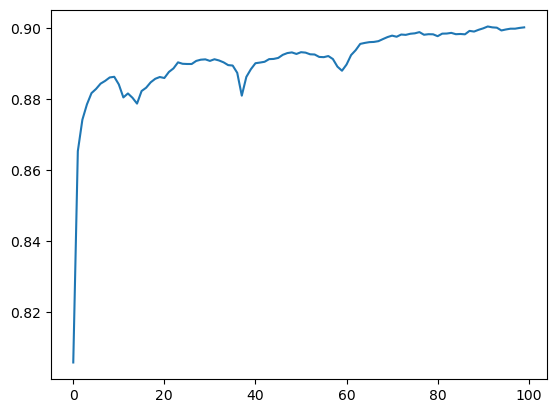

In [29]:
plt.plot(trainingAcc)

In [103]:
model=faceAnalytics()
model=torch.load("/home/csgrad/byalavar/FHE/HEAAN/modelUsing0.pt")
model.to(device)
model.test(dataloader,device)

ageAccuracy:  0.638671875
ageAccuracy:  0.62109375
ageAccuracy:  0.6087239583333334
ageAccuracy:  0.6162109375
ageAccuracy:  0.626953125
ageAccuracy:  0.6259765625
ageAccuracy:  0.62890625
ageAccuracy:  0.628662109375
ageAccuracy:  0.6271701388888888
ageAccuracy:  0.6259765625
ageAccuracy:  0.6296164772727273
ageAccuracy:  0.6300455729166666
ageAccuracy:  0.6275540865384616
ageAccuracy:  0.6256975446428571
ageAccuracy:  0.62578125
ageAccuracy:  0.627197265625
ageAccuracy:  0.6246553308823529
ageAccuracy:  0.6252170138888888
ageAccuracy:  0.6258223684210527
ageAccuracy:  0.62392578125
ageAccuracy:  0.6255580357142857
ageAccuracy:  0.6242009943181818
ageAccuracy:  0.6240658967391305
ageAccuracy:  0.624267578125
ageAccuracy:  0.6246875
ageAccuracy:  0.6246995192307693
ageAccuracy:  0.6237702546296297
ageAccuracy:  0.6241629464285714
ageAccuracy:  0.6245285560344828
ageAccuracy:  0.6251953125
ageAccuracy:  0.6246219758064516
ageAccuracy:  0.62457275390625
ageAccuracy:  0.6244081439393939
a

(0.9118510045752934, 4815.783493041992)

In [38]:
torch.save(model,"modelUsing0.pt")

In [82]:
count=0
for param in model.parameters():
    print(param.shape)
    count=count+1
    if(count==2):
        print(param)

torch.Size([512, 128])
torch.Size([512])
Parameter containing:
tensor([-0.0608, -0.0217,  0.0529, -0.0089,  0.0091,  0.0046, -0.0850,  0.0737,
         0.0143,  0.0217, -0.0977,  0.0810, -0.0564,  0.0011,  0.0722, -0.0247,
         0.0400, -0.0504, -0.0266,  0.0041,  0.0306, -0.0060, -0.0088, -0.0187,
         0.0724, -0.0828, -0.0848, -0.0345, -0.0290,  0.0105,  0.0145, -0.0039,
        -0.0052, -0.0191,  0.0698, -0.0620, -0.0487, -0.1063,  0.0467, -0.0002,
         0.0537,  0.0358, -0.0329,  0.0654, -0.0006, -0.1011, -0.0192, -0.0640,
        -0.0694,  0.0320, -0.1085,  0.0418, -0.0238, -0.0615, -0.0560,  0.0657,
        -0.0512,  0.0451, -0.0391,  0.0244, -0.0777, -0.0340,  0.0475,  0.0886,
         0.0003, -0.0109, -0.0577, -0.0619, -0.0323, -0.0008, -0.0176,  0.0066,
         0.0504,  0.0278, -0.0135,  0.0303,  0.0313, -0.0311,  0.0308, -0.0487,
         0.0603, -0.0842,  0.0063, -0.0263,  0.0686,  0.0789,  0.0931,  0.0091,
        -0.0183, -0.0787,  0.0457,  0.0954,  0.0281, -0.0

In [52]:
a=nn.Linear(4,2)
input1=torch.rand((1,4))
print("input1",input1)
for param in a.parameters():
    print("param",param)
print(a(input1))


input1 tensor([[0.1725, 0.7784, 0.7692, 0.3667]])
param Parameter containing:
tensor([[ 0.0794, -0.2791,  0.0171, -0.2814],
        [-0.0677, -0.3197, -0.2683, -0.3466]], requires_grad=True)
param Parameter containing:
tensor([ 0.0877, -0.3602], requires_grad=True)
tensor([[-0.2058, -0.9542]], grad_fn=<AddmmBackward0>)


In [70]:
model=faceAnalytics()
model=torch.load("modelUsing0.pt")
model.to(device)
count=0
ageBias=[]
for param in model.parameters(): 
    print(param.shape)
    if(count==7):
       ageBias = param.tolist()
    count=count+1
print(len(ageBias),len(ageBias[0]))


torch.Size([512, 128])
torch.Size([512])
torch.Size([128, 512])
torch.Size([128])
torch.Size([2, 128])
torch.Size([2])
torch.Size([1, 128])
torch.Size([1])


TypeError: object of type 'float' has no len()

In [71]:
ageBias

[0.09601110219955444]

In [41]:
bias2

[0.007277209311723709,
 -0.0321158841252327,
 -0.031418390572071075,
 -0.006457424722611904,
 0.0034283681306988,
 0.018647771328687668,
 0.010360945016145706,
 -0.046598006039857864,
 -0.05573476478457451,
 0.01843833737075329,
 0.0027071069926023483,
 0.03294723108410835,
 0.02504689060151577,
 -0.03142755106091499,
 -0.022691987454891205,
 0.03483140096068382,
 -0.05341877415776253,
 0.04222894087433815,
 -0.01728733628988266,
 -0.04929398000240326,
 0.00046024261973798275,
 -0.044817082583904266,
 0.0034655649214982986,
 -0.03304927796125412,
 -0.0016231774352490902,
 -0.04087826982140541,
 0.01253503654152155,
 -0.030864598229527473,
 -0.013328468427062035,
 0.012476014904677868,
 -0.037187058478593826,
 0.006219789385795593,
 -0.013966446742415428,
 0.01565675437450409,
 0.0035794111900031567,
 -0.005585063714534044,
 0.006055895704776049,
 0.00048314392915926874,
 -0.010381164960563183,
 -0.018931696191430092,
 0.012918422929942608,
 0.014919551089406013,
 -0.015488061122596264,

In [68]:
# Create a list of lists with shape (512, 128)


# Define the directory where you want to save the text files
output_directory = "ageWeights"

# Create the output directory if it doesn't exist
import os
os.makedirs(output_directory, exist_ok=True)

# Write each list to a separate text file


# Write each list to a separate text file
for i, sublist in enumerate(ageWeights):
    # Define the file name with leading zeros
    file_name = f"{i:03d}.txt"

    # Write each value in the sublist on a new line
    with open(os.path.join(output_directory, file_name), "w") as file:
        for value in sublist:
            file.write(f"{value}\n")

print("Files saved successfully.")


Files saved successfully.


In [32]:
count=1
layer1Bias=[]
for param in model.parameters(): 
    print(param.shape)
    if(count==2):
       layer1Bias = param.tolist()
       break
    count=count+1
print(len(layer1Bias),len(layer1Bias[0]))

torch.Size([512, 128])
torch.Size([512])


TypeError: object of type 'float' has no len()

In [72]:
output_directory=""
file_name = "ageBias.txt"

with open(os.path.join(output_directory, file_name), "w") as file:
        for value in ageBias:
            file.write(f"{value}\n")